In [1]:
import collections
import pickle

import scipy
import sklearn
import sklearn.preprocessing
import torch
import torch_geometric
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from torch_geometric.data import Data

def plot_out_degree(data: Data):
    node_out_degree = pyg_utils.degree(
        data.edge_index[0], num_nodes=data.num_nodes)
    node_out_degree = (node_out_degree - node_out_degree.min()) / (node_out_degree.max() - node_out_degree.min())
    column_titles = ['out_degree', 'y']
    df = pd.DataFrame(torch.cat((node_out_degree.reshape(-1, 1), data.y.reshape(-1, 1)), dim=-1), columns=column_titles)
    sns.catplot(data=df, kind="bar", x="y", y="out_degree")
    
def plot_temporal_frequency(data: Data):
    column_titles = ['avg_interval', 'y']
    df = pd.DataFrame(torch.cat((data.node_mean_out_time_interval, data.y.reshape(-1, 1)), dim=-1), columns=column_titles)
    sns.catplot(data=df, kind="bar", x="y", y="avg_interval")
    
def compare_out_degree(data: Data):
    benign_mask = data.y == 0
    fraud_mask = data.y == 1
    node_out_degree = pyg_utils.degree(
        data.edge_index[0], num_nodes=data.num_nodes)
    print(f"Out degree benign: {node_out_degree[benign_mask].mean()}")
    print(f"Out degree fraud: {node_out_degree[fraud_mask].mean()}")
    print(f"Out degree fraud/benign: {(node_out_degree[fraud_mask].mean() / node_out_degree[benign_mask].mean()).item()}")
    
def compare_temporal_frequency(data: Data):
    def _get_mean_out_time_interval(series: pd.core.series.Series) -> pd.core.series.Series:
        if series.shape[0] <= 1:
            return 0
        return np.diff(np.sort(series)).mean()
    
    node_out_times = pd.DataFrame(
        np.concatenate(
            (data.edge_index[0].reshape(-1, 1), data.edge_time.int().reshape(-1, 1)), axis=-1),
        columns=["node_out", "time"])
    edge_mean_out_time_interval = node_out_times.groupby("node_out").agg(_get_mean_out_time_interval)
    node_mean_out_time_interval = np.zeros(data.num_nodes)
    node_mean_out_time_interval[edge_mean_out_time_interval.index] = edge_mean_out_time_interval.values.flatten()
    node_mean_out_time_interval = torch.tensor(node_mean_out_time_interval.reshape(-1, 1),
                                               dtype=data.edge_time.dtype)
    
    benign_mask = data.y == 0
    fraud_mask = data.y == 1
    print(f"Temporal Frequency benign: {node_mean_out_time_interval[benign_mask].mean()}")
    print(f"Temporal Frequency fraud: {node_mean_out_time_interval[fraud_mask].mean()}")
    print(f"Temporal Frequency fraud/benign: {(node_mean_out_time_interval[fraud_mask].mean() / node_mean_out_time_interval[benign_mask].mean()).item()}")

def compare_heterophily(data: Data):
    edge_labels = data.y[data.edge_index]
    fraud_edges_mask = (edge_labels[0] == 1) | (edge_labels[1] == 1)
    benign_edges_mask = (edge_labels[0] == 0) | (edge_labels[1] == 0)
    fraud_edge_index = data.edge_index.t()[fraud_edges_mask].t()
    benign_edge_index = data.edge_index.t()[benign_edges_mask].t()
    print(f"Benign homophily: {pyg_utils.homophily(benign_edge_index, data.y)}")
    print(f"Fraud homophily: {pyg_utils.homophily(fraud_edge_index, data.y)}")
    
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## YelpCHI

In [9]:
yelp = pickle.load(open('yelp.dat', 'rb'))
yelp

Data(x=[45954, 32], edge_index=[2, 7693958], y=[45954], train_mask=[45954], val_mask=[45954], test_mask=[45954])

In [20]:
edge_idxs = np.arange(yelp.edge_index[0].shape[0])
edge_idxs

array([      0,       1,       2, ..., 7693955, 7693956, 7693957])

In [26]:
node_idxs = np.arange(yelp.num_nodes)
node_idxs[yelp.train_mask]

array([    0,     1,     3, ..., 45951, 45952, 45953])

In [36]:
yelp.edge_index, yelp.y[yelp.edge_index[0]]

(tensor([[    2,  6702,     4,  ..., 45949, 45953, 45952],
         [    0,     0,     1,  ..., 45950, 45952, 45953]]),
 tensor([0, 1, 0,  ..., 0, 0, 0]))

In [28]:
32767 / 45954

0.7130391260826043

In [10]:
compare_heterophily(yelp)

Benign homophily: 0.767094612121582
Fraud homophily: 0.1011774092912674


In [4]:
compare_out_degree(yelp)

Out degree benign: 168.6560516357422
Out degree fraud: 160.1997833251953
Out degree fraud/benign: 0.9498608708381653


In [19]:
node_out_degree = pyg_utils.degree(
    yelp.edge_index[0], num_nodes=yelp.num_nodes).numpy()
node_out_degree - node_out_degree.min(0), node_out_degree.max(0)

(array([2., 1., 2., ..., 0., 1., 1.], dtype=float32), 501.0)

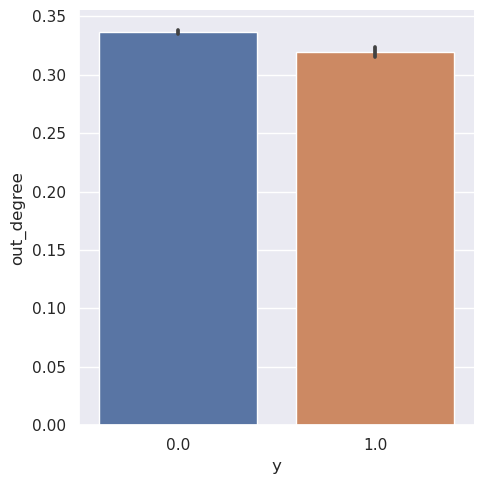

In [21]:
plot_out_degree(yelp)

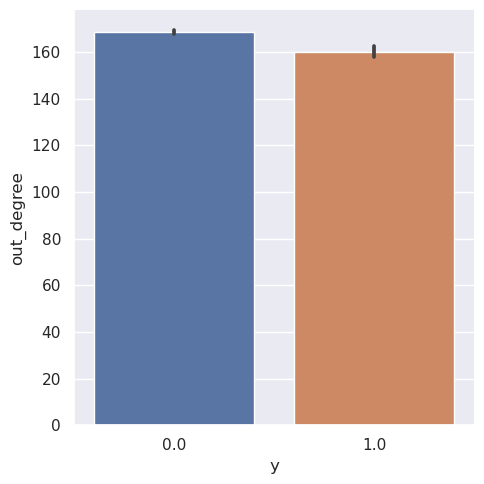

In [16]:
sns.catplot(data=df, kind="bar", x="y", y="out_degree")

In [15]:
column_titles = []
column_titles.append('out_degree')
column_titles.append('y')

df = pd.DataFrame(np.concatenate((node_out_degree.reshape(-1, 1), yelp.y.reshape(-1, 1).numpy()), axis=-1))
df.columns = column_titles
df

,out_degree,y
0,2.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,0.0
4,2.0,0.0
...,...,...
45949,1.0,0.0
45950,1.0,0.0
45951,0.0,0.0
45952,1.0,0.0


In [11]:
(yelp.y == 1).sum()

tensor(6677)

In [13]:
yelp = scipy.io.loadmat("YelpChi.mat")
yelp

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 19 20:09:02 2020',
 '__version__': '1.0',
 '__globals__': [],
 'homo': <45954x45954 sparse matrix of type '<class 'numpy.float64'>'
 	with 7693958 stored elements in Compressed Sparse Column format>,
 'net_rur': <45954x45954 sparse matrix of type '<class 'numpy.float64'>'
 	with 98630 stored elements in Compressed Sparse Column format>,
 'net_rtr': <45954x45954 sparse matrix of type '<class 'numpy.float64'>'
 	with 1147232 stored elements in Compressed Sparse Column format>,
 'net_rsr': <45954x45954 sparse matrix of type '<class 'numpy.float64'>'
 	with 6805486 stored elements in Compressed Sparse Column format>,
 'features': <45954x32 sparse matrix of type '<class 'numpy.float64'>'
 	with 1469088 stored elements in Compressed Sparse Column format>,
 'label': array([[0, 0, 0, ..., 0, 0, 0]])}

In [3]:
y = yelp['label'].flatten()
y, y.shape

(array([0, 0, 0, ..., 0, 0, 0]), (45954,))

In [4]:
pd.DataFrame(y).value_counts()

0    39277
1     6677
dtype: int64

In [5]:
x = yelp['features'].todense().A
x, x.shape

(array([[0.02237555, 0.07049484, 0.42868165, ..., 0.5920398 , 0.13930348,
         0.49751244],
        [0.02492767, 0.99998516, 0.99998516, ..., 0.5920398 , 0.13930348,
         0.49751244],
        [0.00617256, 0.07049484, 0.42868165, ..., 0.5920398 , 0.13930348,
         0.49751244],
        ...,
        [0.00908079, 0.35002597, 0.42868165, ..., 0.48258706, 0.80099502,
         0.1641791 ],
        [0.00617256, 0.07049484, 0.99998516, ..., 0.44278607, 0.44776119,
         0.58706468],
        [0.00317531, 0.35002597, 0.42868165, ..., 0.44278607, 0.44776119,
         0.58706468]]),
 (45954, 32))

In [15]:
adj = yelp['homo'].tocoo()
adj

<45954x45954 sparse matrix of type '<class 'numpy.float64'>'
	with 7693958 stored elements in COOrdinate format>

In [16]:
edge_index = torch.tensor(np.stack([adj.row, adj.col]), dtype=torch.int64)
edge_index

tensor([[    2,  6702,     4,  ..., 45949, 45953, 45952],
        [    0,     0,     1,  ..., 45950, 45952, 45953]])

In [8]:
torch_geometric.utils.is_undirected(edge_index)

True

In [9]:
adj.row, adj.col

(array([    2,  6702,     4, ..., 45949, 45953, 45952], dtype=int32),
 array([    0,     0,     1, ..., 45950, 45952, 45953], dtype=int32))

In [10]:
pyg_utils.homophily(edge_index, torch.tensor(y))

0.773044764995575

### Degrees

In [67]:
in_degrees = pyg_utils.degree(edge_index[1], dtype=torch.float)
out_degrees = pyg_utils.degree(edge_index[0], dtype=torch.float)
torch.mean(in_degrees), torch.mean(out_degrees)

(tensor(167.4274), tensor(167.4274))

In [71]:
outdegrees_normalized = out_degrees.reshape(-1, 1)
outdegrees_normalized = (outdegrees_normalized - outdegrees_normalized.mean(0)) / outdegrees_normalized.std(0)
outdegrees_normalized

tensor([[-1.7388],
        [-1.7493],
        [-1.7388],
        ...,
        [-1.7598],
        [-1.7493],
        [-1.7493]])

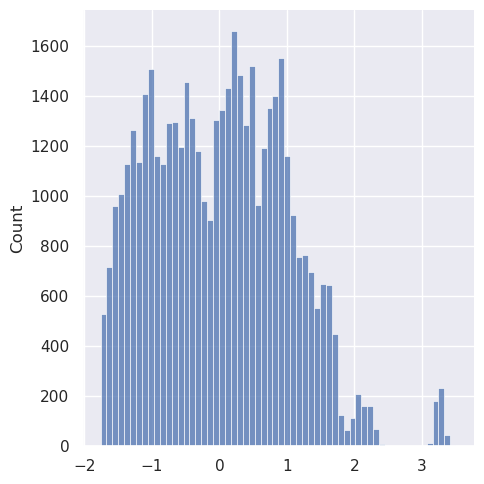

In [75]:
sns.displot(outdegrees_normalized.squeeze().numpy())

In [12]:
torch.mean(out_degrees[y == 1].to(torch.float))

tensor(160.1998)

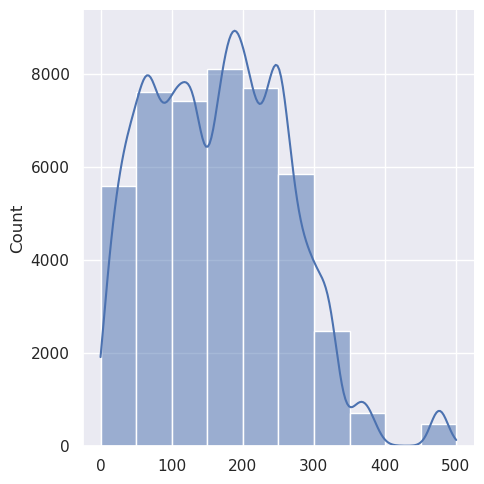

In [13]:
sns.set_theme()
# 所有节点出度
sns.displot(out_degrees, bins=10, kde=True)

In [14]:
degrees_compare = [torch.mean(out_degrees[y == 0].to(torch.float)).item(), torch.mean(out_degrees[y == 1].to(torch.float)).item()]
degrees_compare

[168.6560516357422, 160.1997833251953]

### Neighbor Similarity

In [38]:
np.linalg.norm(x[edge_index[0]][0], ord=1)

17.819169595745226

In [42]:
test = np.ones((3,5), dtype=np.float32)
test, np.linalg.norm(test, ord=2, axis=1, keepdims=True)

(array([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], dtype=float32),
 array([[2.236068],
        [2.236068],
        [2.236068]], dtype=float32))

In [44]:
i_norm = np.linalg.norm(x[edge_index[0]], ord=2, axis=1, keepdims=True)
j_norm = np.linalg.norm(x[edge_index[1]], ord=2, axis=1, keepdims=True)
i_norm, j_norm

(array([[3.77375791],
        [3.60540549],
        [3.84871797],
        ...,
        [3.90843852],
        [3.2505137 ],
        [3.91667839]]),
 array([[3.88976365],
        [3.88976365],
        [4.13319347],
        ...,
        [3.51430301],
        [3.91667839],
        [3.2505137 ]]))

In [33]:
neighbor_dotproducts = np.sum(x[edge_index[0]] * x[edge_index[1]], axis=-1, keepdims=True)
neighbor_dotproducts

array([[13.38003657],
       [11.69483234],
       [14.61632905],
       ...,
       [10.70375997],
       [ 9.91148127],
       [ 9.91148127]])

In [45]:
neighbor_similarities = neighbor_dotproducts / (i_norm * j_norm)
neighbor_similarities

array([[0.91150709],
       [0.83390518],
       [0.9188328 ],
       ...,
       [0.77928061],
       [0.77851799],
       [0.77851799]])

In [57]:
neighbor_similarities_all = np.concatenate((y[edge_index[0]].reshape(-1,1), edge_index[0].view(-1, 1).numpy(), neighbor_similarities), axis=-1)
neighbor_similarities_all

array([[0.00000000e+00, 2.00000000e+00, 9.11507088e-01],
       [1.00000000e+00, 6.70200000e+03, 8.33905178e-01],
       [0.00000000e+00, 4.00000000e+00, 9.18832800e-01],
       ...,
       [0.00000000e+00, 4.59490000e+04, 7.79280614e-01],
       [0.00000000e+00, 4.59530000e+04, 7.78517989e-01],
       [0.00000000e+00, 4.59520000e+04, 7.78517989e-01]])

In [61]:
avg_neighbor_similarities = pd.DataFrame(neighbor_similarities_all).groupby(1).mean()
avg_neighbor_similarities.groupby(0).mean()

,2
0,
0.0,0.861715
1.0,0.852941


In [53]:
avg_neighbor_similarities.to_numpy()[y == 0]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 45941 but corresponding boolean dimension is 45954

## DGraph

In [5]:
def get_typical_fraudster_subgraph(): 
    """抽样欺诈者模式"""
    sample_fraudster = index_fraud[torch.randint(0, index_fraud.shape[0], size=(1,))].item()
    nodes, edges, _, edge_mask  = pyg_utils.k_hop_subgraph(sample_fraudster, 2, dgraph.edge_index, relabel_nodes=False, num_nodes=dgraph.num_nodes)
    labels, edge_time = dgraph.y[nodes], dgraph.edge_time[edge_mask]
    print(f"fraud node: {sample_fraudster}")
    print(f"nodes: {nodes}")
    print(f"labels: {labels}")
    print(f"edges: \n{edges.T}")
    print(f"edge times: {edge_time.squeeze()}")
    nodes, edges, _, edge_mask  = pyg_utils.k_hop_subgraph(sample_fraudster, 2, dgraph.edge_index, relabel_nodes=False, num_nodes=dgraph.num_nodes, flow="target_to_source")
    labels, edge_time = dgraph.y[nodes], dgraph.edge_time[edge_mask]
    print(f"\nTarget to source:\n")
    print(f"fraud node: {sample_fraudster}")
    print(f"nodes: {nodes}")
    print(f"labels: {labels}")
    print(f"edges: \n{edges.T}")
    print(f"edge times: {edge_time.squeeze()}")

def handle_missing_x(x: np.ndarray) -> np.ndarray:
    """使用TrickB处理缺失值"""
    x_new = x.copy()
    x_missing_flag = x_new == -1.
    x_missing_flag = np.where(x_missing_flag, 1., 0.)
    x_new[x_new == -1.] = 0.
    x_new = np.concatenate((x_new, x_missing_flag), axis=-1)
    return x_new

def standardize(x: np.ndarray):
    """Z-Score标准化"""
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(x)
    x_transformed = scaler.transform(x)
    return x_transformed

def _read_dgraphfin(max_time_steps=32) -> Data:
    print('Reading DGraph...')
    item: dict = np.load("DGraph/dgraphfin.npz")

    x = item['x']
    y = item['y']
    edge_index = item['edge_index']
    edge_type = item['edge_type']
    train_mask = item['train_mask']
    val_mask = item['valid_mask']
    test_mask = item['test_mask']
    edge_time = item['edge_timestamp']

    x = torch.tensor(x, dtype=torch.float).contiguous()
    y = torch.tensor(y, dtype=torch.int64)
    edge_index = torch.tensor(edge_index.transpose(), dtype=torch.int64).contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.float)
    train_mask = torch.tensor(train_mask, dtype=torch.int64)
    val_mask = torch.tensor(val_mask, dtype=torch.int64)
    test_mask = torch.tensor(test_mask, dtype=torch.int64)
    edge_time = torch.tensor(edge_time, dtype=torch.int64)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_type, y=y)
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    data.edge_time = edge_time
    
    data.edge_time = data.edge_time - data.edge_time.min()  # process edge time
    data.edge_time = data.edge_time / data.edge_time.max()
    data.edge_time = (data.edge_time * max_time_steps).long()
    data.edge_time = data.edge_time.view(-1, 1).float()

    return data

# dgraph = np.load("DGraph/dgraphfin.npz")
# x_raw = dgraph['x']
# idx_train = dgraph['train_mask']
# y = dgraph['y']
# edge_index = dgraph['edge_index']
# edge_time = dgraph['edge_timestamp']

# # 处理缺失值
# x = handle_missing_x(x_raw)

# # 标准化
# x = standardize(x)

# x_raw, x
dgraph = _read_dgraphfin()
index_fraud = pyg_utils.mask_to_index(dgraph.y == 1)
edge_index_undirected, edge_time_undirected = pyg_utils.to_undirected(dgraph.edge_index, dgraph.edge_time)
dgraph

Reading DGraph...


Data(x=[3700550, 17], edge_index=[2, 4300999], edge_attr=[4300999], y=[3700550], train_mask=[857899], val_mask=[183862], test_mask=[183840], edge_time=[4300999, 1])

In [31]:
pyg_utils.contains_self_loops(dgraph.edge_index)

False

In [6]:
import torchmetrics

In [37]:
target = torch.tensor([1,0,0,0,1,0], dtype=torch.int)
logits = torch.tensor([0.3,0.1,0.1,0.2,0.1,0.5], dtype=torch.float32)

logits_multiclass = torch.stack([1 - logits, logits]).transpose(0,1)

In [38]:
logits_multiclass.softmax(-1)

tensor([[0.5987, 0.4013],
        [0.6900, 0.3100],
        [0.6900, 0.3100],
        [0.6457, 0.3543],
        [0.6900, 0.3100],
        [0.5000, 0.5000]])

In [43]:
torchmetrics.functional.classification.multiclass_average_precision(logits_multiclass, target, 2)

tensor(0.5521)

In [41]:
torchmetrics.functional.classification.binary_average_precision(logits, target)

tensor(0.4167)

In [60]:
get_typical_fraudster_subgraph()

fraud node: 1743330
nodes: tensor([1743330])
labels: tensor([1])
edges: 
tensor([], size=(0, 2), dtype=torch.int64)
edge times: tensor([])

Target to source:

fraud node: 1743330
nodes: tensor([1743330, 2126859, 2805677, 3205098, 3283869])
labels: tensor([1, 2, 3, 2, 2])
edges: 
tensor([[1743330, 3283869],
        [2126859, 3205098],
        [1743330, 3205098],
        [3283869, 3205098],
        [2126859, 3283869],
        [3283869, 2805677],
        [3283869, 2126859]])
edge times: tensor([18., 16., 16., 18., 18., 18., 18.])


In [29]:
index_fraud

tensor([1.3430e+03, 1.6050e+03, 1.7440e+03,  ..., 3.5660e+06, 3.5662e+06,
        3.6867e+06])

In [33]:
res = pyg_utils.k_hop_subgraph(3566155, 2, dgraph.edge_index, relabel_nodes=False, num_nodes=dgraph.num_nodes)
res

(tensor([ 150036, 2805333, 3566155]),
 tensor([[ 150036, 2805333],
         [2805333, 3566155]]),
 tensor([2]),
 tensor([False, False, False,  ..., False, False, False]))

In [34]:
np.random.choice(index_fraud)

288618

In [7]:
compare_out_degree(dgraph)

Out degree benign: 1.7281520366668701
Out degree fraud: 0.7471790313720703
Out degree fraud/benign: 0.43235722184181213


In [8]:
compare_temporal_frequency(dgraph)

Temporal Frequency benign: 2.823336601257324
Temporal Frequency fraud: 0.5692458152770996
Temporal Frequency fraud/benign: 0.2016216665506363


In [11]:
compare_heterophily(dgraph)

Benign homophily: 0.2665351927280426
Fraud homophily: 0.008280953392386436


In [55]:
edge_labels = dgraph.y[dgraph.edge_index]
fraud_edges_mask = (edge_labels[0] == 1) | (edge_labels[1] == 1)
fraud_edge_index = dgraph.edge_index.t()[fraud_edges_mask].t()
pyg_utils.homophily(fraud_edge_index, dgraph.y), pyg_utils.homophily(dgraph.edge_index, dgraph.y)

(0.008280953392386436, 0.3671160936355591)

In [10]:
x = torch.tensor(x, dtype=torch.float).contiguous()
y = torch.tensor(y, dtype=torch.int64)
edge_index = torch.tensor(edge_index.transpose(), dtype=torch.int64).contiguous()
edge_index

tensor([[ 476699,  347800,  154317,  ..., 1894383, 1895741, 1206795],
        [2915516, 1271242, 2104635,  ..., 1147595, 1314434, 2072636]])

In [16]:
# 转换到高维
linear = torch.nn.Linear(34, 128)
x = linear(torch.tensor(x, dtype=torch.float)).detach().numpy()
x, x.shape

(array([[-0.36722547,  0.61754096, -0.18552598, ..., -0.16380723,
          0.07712935, -0.18658462],
        [ 0.32765448,  0.3658078 , -0.73488957, ...,  0.43619987,
          0.39385974,  0.40020907],
        [-0.36722547,  0.61754096, -0.18552598, ..., -0.16380723,
          0.07712935, -0.18658462],
        ...,
        [ 0.32765448,  0.3658078 , -0.73488957, ...,  0.43619987,
          0.39385974,  0.40020907],
        [ 0.32765448,  0.3658078 , -0.73488957, ...,  0.43619993,
          0.39385977,  0.4002091 ],
        [ 0.32765448,  0.3658078 , -0.73488957, ...,  0.43619993,
          0.39385977,  0.4002091 ]], dtype=float32),
 (3700550, 128))

In [3]:
x = dgraph['x']
x

array([[ 0.,  5., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 0.,  5., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [28]:
c = torch.tensor([1, 2, 3])
d = torch.tensor([1, 2, 3])
a = torch.tensor([1, 2, 3, 4, 5, 6]).reshape(2, -1)
b = torch.tensor([1, 2, 3, 8, 9, 7]).reshape(2, -1)
# diff = torch.dot(a,b).unsqueeze(dim=-1)
# torch.cat([a, b, diff], dim=-1)
a, b, (a * b).sum(-1, keepdim=True)

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 tensor([[1, 2, 3],
         [8, 9, 7]]),
 tensor([[ 14],
         [119]]))

### 时频

In [10]:
df = pd.DataFrame(np.concatenate((edge_index[0].reshape(-1, 1), edge_time.reshape(-1, 1)), axis=-1), columns=["node_out", "time"])
df

,node_out,time
0,476699,254
1,2915516,266
2,347800,240
3,1271242,474
4,154317,7
...,...,...
4300994,3361187,745
4300995,3549842,483
4300996,2186582,378
4300997,1580594,594


In [112]:
def get_mean_out_time_interval(series: pd.core.series.Series) -> pd.core.series.Series:
    if series.shape[0] <= 1:
        return 0
    return np.diff(np.sort(series)).mean()

In [137]:
node_mean_out_time_interval = np.zeros(x.shape[0])
node_mean_out_time_interval.shape

(3700550,)

In [126]:
edge_mean_out_time_interval = df[:50].groupby("node_out").agg(get_mean_out_time_interval)

In [150]:
type(edge_mean_out_time_interval.index)

pandas.core.indexes.numeric.Int64Index

In [146]:
node_mean_out_time_interval[edge_mean_out_time_interval.index] = edge_mean_out_time_interval.values.flatten()
node_mean_out_time_interval

array([0., 0., 0., ..., 0., 0., 0.])

### 邻居相似度

In [4]:
undirected_edge_index = pyg_utils.to_undirected(torch.tensor(edge_index), num_nodes=len(y))

use_edge_index = edge_index

benign_benign_neighbor_mask = (y[use_edge_index[0]] == 0) * (y[use_edge_index[1]] == 0)
fraud_fraud_neighbor_mask = (y[use_edge_index[0]] == 1) * (y[use_edge_index[1]] == 1)
benign_src_mask = y[use_edge_index[0]] == 0
fraud_dst_mask = y[use_edge_index[1]] == 1
fraud_src_mask = y[use_edge_index[0]] == 1
benign_fraud_neighbor_mask = benign_src_mask * fraud_dst_mask

def plot_neighbor_similarity(mask: np.ndarray, calc_similarity, plot=sns.displot):
    x_mask_i = x[use_edge_index[0]][mask]
    x_mask_j = x[use_edge_index[1]][mask]
    neighbor_similarity = calc_similarity(torch.tensor(x_mask_i), torch.tensor(x_mask_j))
    print(f"max neighbor similarity: {neighbor_similarity.max()}")
    print(f"min neighbor similarity: {neighbor_similarity.min()}")
    print(f"mean neighbor similarity: {neighbor_similarity.mean()}")
    print(f"std neighbor similarity: {neighbor_similarity.std()}")
    plot(neighbor_similarity)

max neighbor similarity: 1.0000001192092896
min neighbor similarity: -0.9826086163520813
mean neighbor similarity: 0.1072159856557846
std neighbor similarity: 0.7550652623176575


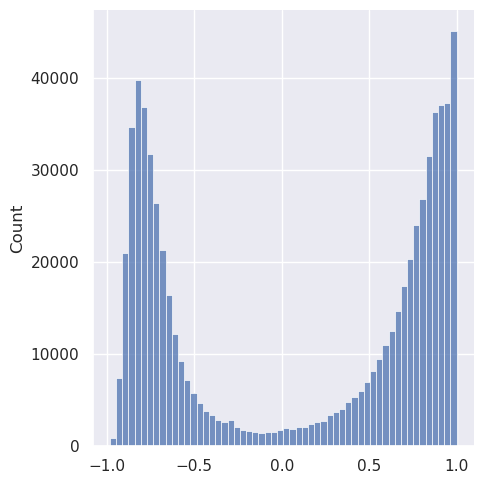

In [5]:
# 正常<->正常的邻居相似度
plot_neighbor_similarity(benign_benign_neighbor_mask, torch.cosine_similarity)

max neighbor similarity: 1.0
min neighbor similarity: -0.8691445589065552
mean neighbor similarity: 0.06352081894874573
std neighbor similarity: 0.8108976483345032


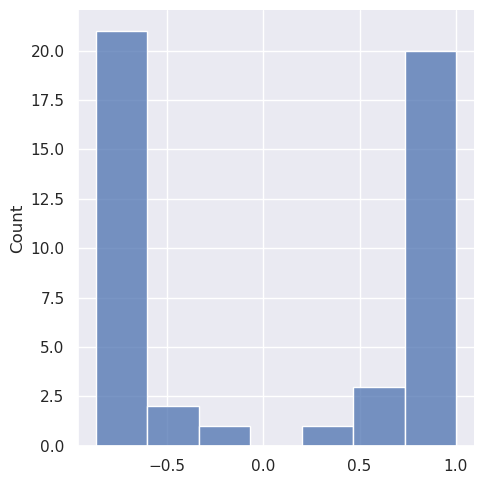

In [6]:
# 异常<->异常的邻居相似度
plot_neighbor_similarity(fraud_fraud_neighbor_mask, torch.cosine_similarity)

max neighbor similarity: 1.0000001192092896
min neighbor similarity: -0.9707982540130615
mean neighbor similarity: -0.0506836473941803
std neighbor similarity: 0.7744297981262207


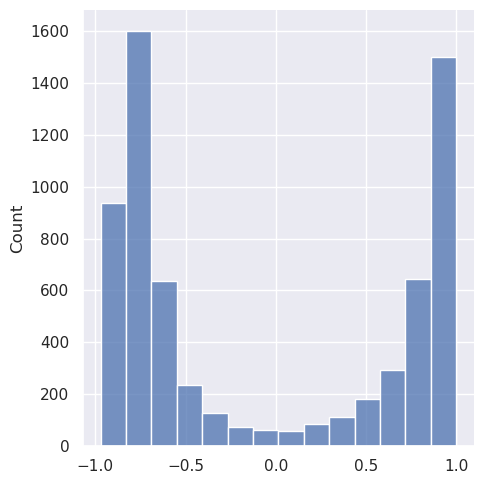

In [7]:
# 正常<->异常的邻居相似度
plot_neighbor_similarity(benign_fraud_neighbor_mask, torch.cosine_similarity)

In [7]:
fraud_benign_neighbor_mask = (y[use_edge_index[0]] == 1) * (y[use_edge_index[1]] == 0)
fraud_benign_neighbor_mask, fraud_benign_neighbor_mask.sum()

(array([False, False, False, ..., False, False, False]), 6472)

max neighbor similarity: 1.0000000000000002
min neighbor similarity: -0.9180621112385858
mean neighbor similarity: -0.09519417997327226
std neighbor similarity: 0.7123693023881172


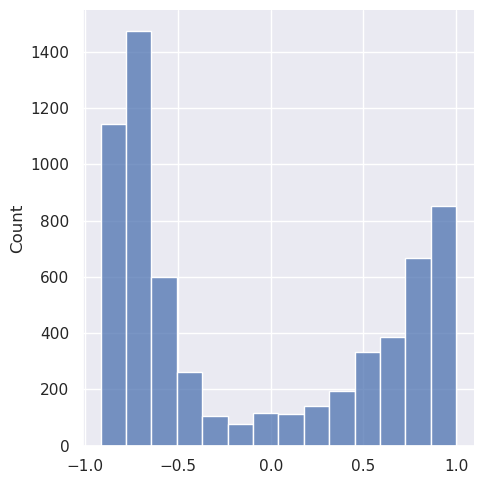

In [8]:
# 异常->正常的邻居相似度
plot_neighbor_similarity(fraud_benign_neighbor_mask, torch.cosine_similarity)

max neighbor similarity: 1.0000000000000002
min neighbor similarity: -0.9373003823376219
mean neighbor similarity: -0.030751629338575667
std neighbor similarity: 0.6881589303550425


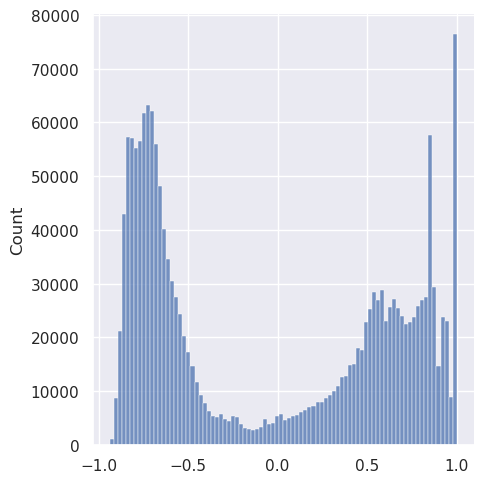

In [18]:
# 正常->XX的邻居相似度
plot_neighbor_similarity(benign_src_mask, torch.cosine_similarity)

max neighbor similarity: 1.0000000000000002
min neighbor similarity: -0.9218301431850527
mean neighbor similarity: -0.056592888591029115
std neighbor similarity: 0.719832777466897


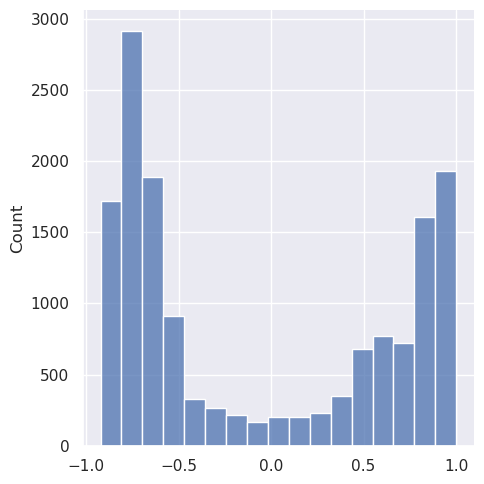

In [19]:
# 异常->XX的邻居相似度
plot_neighbor_similarity(fraud_src_mask, torch.cosine_similarity)

#### L1范数

In [8]:
def l1_similarity(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return 1.0 - torch.pairwise_distance(a,b,p=1)

max neighbor similarity: 0.999966
min neighbor similarity: -1098.2011288197791
mean neighbor similarity: -30.093222654423517
std neighbor similarity: 20.065998256591087


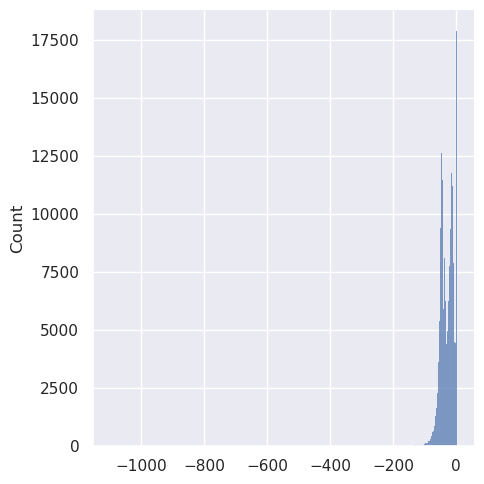

In [9]:
# 正常<->正常的邻居L1相似度
plot_neighbor_similarity(benign_benign_neighbor_mask, l1_similarity)

max neighbor similarity: 0.999966
min neighbor similarity: -63.586982544909034
mean neighbor similarity: -24.62033677340264
std neighbor similarity: 18.713433497945037


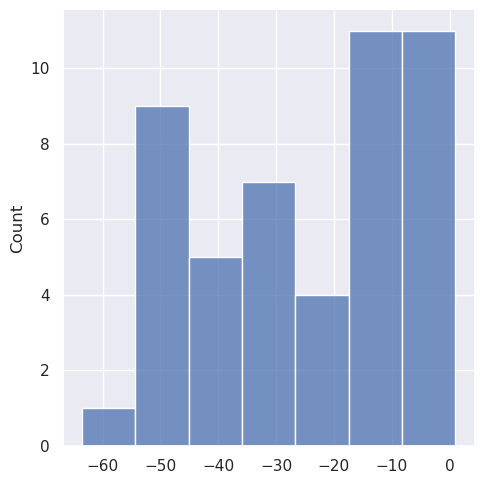

In [10]:
# 异常<->异常的邻居L1相似度
plot_neighbor_similarity(fraud_fraud_neighbor_mask, l1_similarity)

max neighbor similarity: 0.999966
min neighbor similarity: -259.54440856075644
mean neighbor similarity: -31.216514445882453
std neighbor similarity: 20.90402207047862


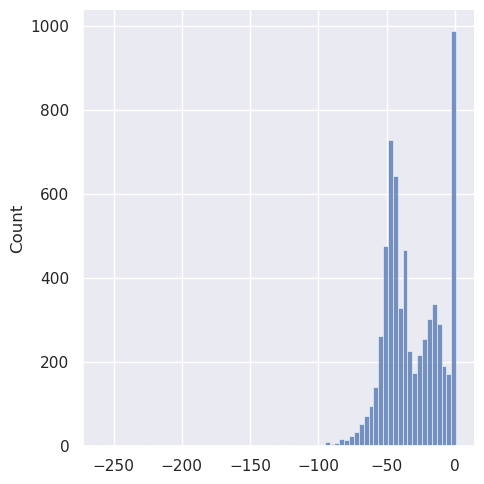

In [11]:
# 正常<->异常的邻居相似度
plot_neighbor_similarity(benign_fraud_neighbor_mask, l1_similarity)

#### L2相似度

In [12]:
def l2_similarity(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.exp(-torch.pairwise_distance(a, b, p=2)**2)

def l2_similarity_alt(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.exp(-torch.pairwise_distance(a, b, p=2))

max neighbor similarity: 0.999999999966
min neighbor similarity: 0.0
mean neighbor similarity: 0.03339229177032828
std neighbor similarity: 0.15534171821830772


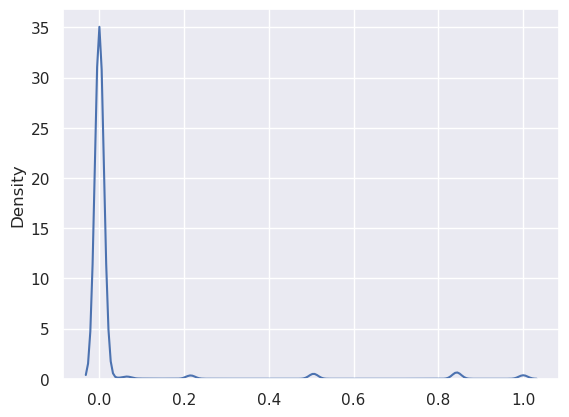

In [13]:
# 正常<->正常的邻居L2相似度
plot_neighbor_similarity(benign_benign_neighbor_mask, l2_similarity, plot=sns.kdeplot)

max neighbor similarity: 0.999999999966
min neighbor similarity: 1.0031160283856044e-128
mean neighbor similarity: 0.09237919884741595
std neighbor similarity: 0.26555854697621606


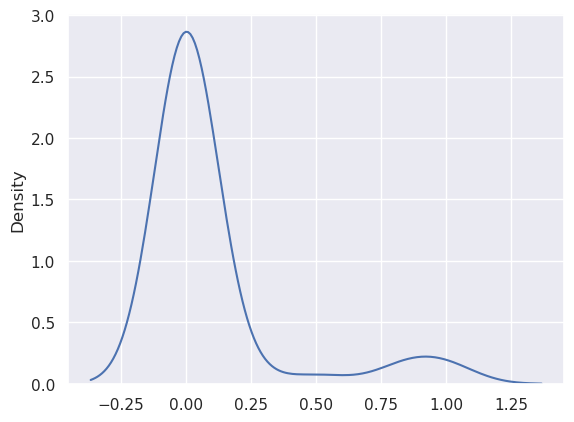

In [14]:
# 异常<->异常的邻居L2相似度
plot_neighbor_similarity(fraud_fraud_neighbor_mask, l2_similarity, plot=sns.kdeplot)

max neighbor similarity: 0.999999999966
min neighbor similarity: 0.0
mean neighbor similarity: 0.05532714894267543
std neighbor similarity: 0.19774029768644075


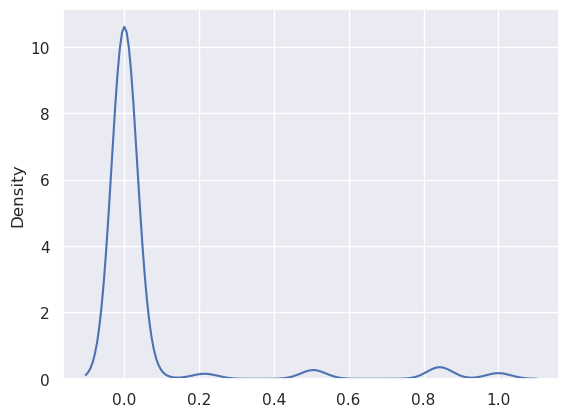

In [15]:
# 正常<->异常的邻居相似度
plot_neighbor_similarity(benign_fraud_neighbor_mask, l2_similarity, plot=sns.kdeplot)

#### 不相似的案例

In [23]:
x_raw.mean(0), x_raw.std(0)

(array([ 0.50768751,  3.07716934, -0.0880759 , -0.1587935 , -0.15363507,
        -0.20288057,  0.08773051, -0.51202765,  0.0667277 , -0.10762143,
         0.73695234, -0.51007654, -0.55609018, -0.5523567 , -0.29223863,
        -0.71767715, -0.63750339]),
 array([0.73781295, 2.63461152, 1.43126751, 1.31247396, 0.92480574,
        1.32907686, 1.91295989, 0.61519935, 1.8746461 , 0.97213829,
        2.44890778, 0.58143874, 0.5241673 , 0.52702853, 0.87805539,
        0.45592401, 0.59561387]))

In [41]:
def pick(index: int, features: torch.Tensor):
    x_sample_i = torch.tensor(features[undirected_edge_index[0]][benign_benign_neighbor_mask][index])
    x_sample_j = torch.tensor(features[undirected_edge_index[1]][benign_benign_neighbor_mask][index])
    y_sample_i = torch.tensor(y[undirected_edge_index[0]][benign_benign_neighbor_mask][index])
    y_sample_j = torch.tensor(y[undirected_edge_index[1]][benign_benign_neighbor_mask][index])
    print(x_sample_i)
    print(x_sample_j)
    print(y_sample_i, y_sample_j)
    print(f"Cosine Similarity: {torch.cosine_similarity(x_sample_i, x_sample_j, dim=0)}")
    print(f"L1 Distance: {l1_similarity(x_sample_i, x_sample_j)}")
    print(f"L2 Similarity: {l2_similarity(x_sample_i, x_sample_j)}")

In [54]:
pick(3, x_raw)

tensor([ 1.,  5., -1., -1., -1., -1., -1., -1., -1., -1.,  0., -1., -1., -1.,
        -1., -1., -1.], dtype=torch.float64)
tensor([1.0000, 2.0000, 0.4250, 0.3600, 0.8471, 0.3000, 0.3380, 0.0570, 0.3250,
        0.9615, 1.0000, 0.1529, 0.0385, 0.0417, 0.3333, 0.0118, 0.3333],
       dtype=torch.float64)
tensor(0) tensor(0)
Cosine Similarity: 0.3508543108127931
L1 Distance: -21.52508503921569
L2 Similarity: 3.585233344579067e-16


In [55]:
pick(3, x)

tensor([1., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
tensor([1.0000, 2.0000, 0.4250, 0.3600, 0.8471, 0.3000, 0.3380, 0.0570, 0.3250,
        0.9615, 1.0000, 0.1529, 0.0385, 0.0417, 0.3333, 0.0118, 0.3333, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
tensor(0) tensor(0)
Cosine Similarity: 0.5960549584094752
L1 Distance: -21.52510203921569
L2 Similarity: 3.0545224641196637e-12


In [54]:
sb = torch.tensor([1.,1.,1.])
sb2 = torch.tensor([1.,0.,1.])
torch.cosine_similarity(sb, sb2, dim=0), l1_similarity(sb, sb2), l2_similarity(sb, sb2)

(tensor(0.8165), tensor(-2.8610e-06), tensor(0.3679))

### 转换为CARE-GNN格式

In [22]:
edge_index_undirected = pyg_utils.to_undirected(torch.tensor(edge_index)).numpy()
edge_index_undirected

array([[      0,       1,       1, ..., 3700548, 3700549, 3700549],
       [3198498, 1049529, 1555191, ..., 3118994,  847917, 2140433]])

In [23]:
edge_index_self_loops_added = pyg_utils.add_self_loops(torch.tensor(edge_index_undirected), num_nodes=x.shape[0])[0].numpy()
edge_index_self_loops_added

array([[      0,       1,       1, ..., 3700547, 3700548, 3700549],
       [3198498, 1049529, 1555191, ..., 3700547, 3700548, 3700549]])

In [9]:
adj_lists = collections.defaultdict(set)
for index, node in enumerate(edge_index_self_loops_added[0]):
    adj_lists[node].add(edge_index_self_loops_added[1][index])
    adj_lists[edge_index_self_loops_added[1][index]].add(node)
len(adj_lists)

3700550

In [10]:
labels = y
labels

array([2, 3, 2, ..., 2, 2, 2])

In [11]:
feat_data = x
feat_data

array([[ 0.,  5., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 0.,  5., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [17]:
homo = adj_lists

In [24]:
pyg_utils.is_undirected(torch.tensor(edge_index_self_loops_added))

True

### 异常节点特性

In [37]:
fraud_neighbor_labels = pd.DataFrame(y[use_edge_index[1]][fraud_src_mask], columns=["y"])
fraud_neighbor_labels.value_counts()

y
0    6472
2    5341
3    3236
1      48
dtype: int64

<Axes: xlabel='y', ylabel='count'>

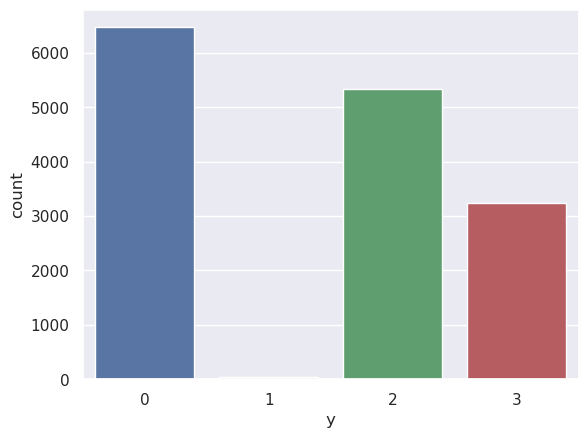

In [45]:
sns.countplot(x=fraud_neighbor_labels["y"])

In [46]:
benign_neighbor_labels = pd.DataFrame(y[use_edge_index[1]][benign_src_mask], columns=["y"])
benign_neighbor_labels.value_counts()

y
0    683903
2    671418
3    386289
1      6538
dtype: int64

<Axes: xlabel='y', ylabel='count'>

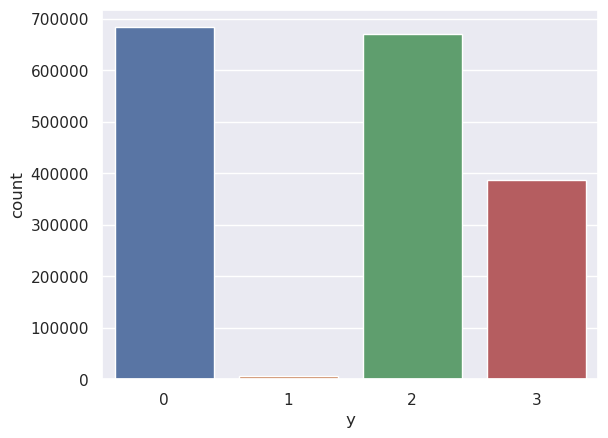

In [47]:
sns.countplot(x=benign_neighbor_labels["y"])

In [3]:
node_out_degree = pyg_utils.degree(
    torch.tensor(edge_index[0]), num_nodes=x.shape[0]).numpy()
node_out_degree

array([1., 0., 1., ..., 1., 0., 1.], dtype=float32)

In [4]:
node_in_degree = pyg_utils.degree(
    torch.tensor(edge_index[1]), num_nodes=x.shape[0]).numpy()
node_in_degree

array([0., 2., 0., ..., 0., 2., 1.], dtype=float32)

In [59]:
benign_neighbor_out_degrees = pd.DataFrame(node_out_degree[use_edge_index[1]][benign_src_mask], columns=["out_degree"])
benign_neighbor_out_degrees.mean()

out_degree    1.382826
dtype: float32

In [60]:
fraud_neighbor_out_degrees = pd.DataFrame(node_out_degree[use_edge_index[1]][fraud_src_mask], columns=["out_degree"])
fraud_neighbor_out_degrees.mean()

out_degree    1.387759
dtype: float32

In [6]:
column_titles = [f'x{i}' for i in range(x.shape[1])]
column_titles.append('out_degree')
column_titles.append('in_degree')
column_titles.append('y')

df = pd.DataFrame(np.concatenate((x, node_out_degree.reshape(-1, 1), node_in_degree.reshape(-1, 1), y.reshape(-1, 1)), axis=-1))
df.columns = column_titles
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x27,x28,x29,x30,x31,x32,x33,out_degree,in_degree,y
0,-1.377577,0.733133,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,0.0,2.0
1,-1.377577,-1.331871,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,0.0,2.0,3.0
2,-1.377577,0.733133,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,0.0,2.0
3,0.725912,0.733133,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,2.0,3.0
4,0.725912,1.559134,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700545,-1.377577,-1.331871,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,0.0,1.0,2.0
3700546,-1.377577,-1.331871,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,0.0,2.0
3700547,-1.377577,-1.331871,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,1.0,0.0,2.0
3700548,-1.377577,-1.331871,-0.396493,-0.372463,-0.900791,-0.361743,-0.380989,-0.285818,-0.377114,-0.914172,...,0.0,0.851015,0.851015,0.851293,0.815657,0.61953,0.61953,0.0,2.0,2.0


In [7]:
df.groupby("y").mean()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x26,x27,x28,x29,x30,x31,x32,x33,out_degree,in_degree
y,,,,,,,,,,,,,,,,,,,,,
0.0,0.196278,0.199726,0.400035,0.362399,0.336827,0.320752,0.425810,0.324825,0.420133,0.370425,...,-0.380125,0.0,-0.379922,-0.379922,-0.394443,-0.393897,-0.366371,-0.366371,1.444641,1.446193
1.0,0.277383,0.271453,-0.221911,-0.204257,-0.202848,-0.160326,-0.232979,-0.172108,-0.230368,-0.218440,...,0.220292,0.0,0.236750,0.236750,0.217596,0.213914,0.135612,0.135612,0.973435,0.981430
2.0,-0.321462,-0.346338,-0.230617,-0.209403,-0.213344,-0.193944,-0.240307,-0.188462,-0.237109,-0.234111,...,0.240086,0.0,0.241611,0.241611,0.253380,0.254657,0.236308,0.236308,0.987449,0.985951
3.0,0.326925,0.369355,-0.125092,-0.112348,-0.068665,-0.083479,-0.143022,-0.099438,-0.141096,-0.076573,...,0.078943,0.0,0.075464,0.075464,0.074050,0.070921,0.068165,0.068165,1.097353,1.097851


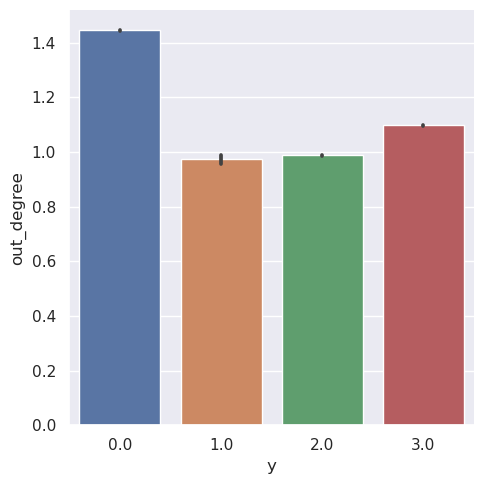

In [17]:
sns.catplot(data=df, kind="bar", x="y", y="out_degree")

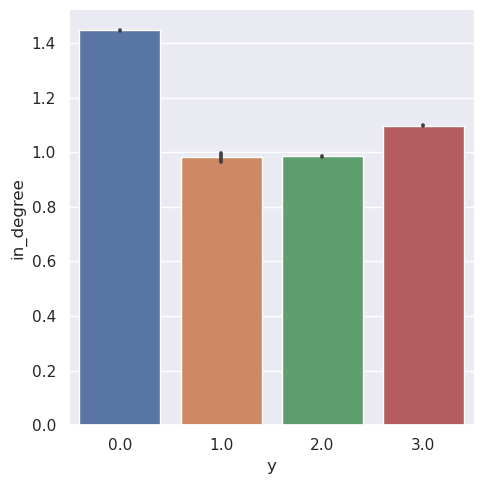

In [8]:
sns.catplot(data=df, kind="bar", x="y", y="in_degree")

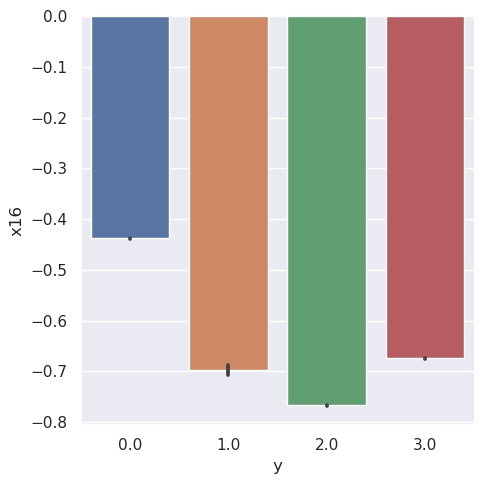

In [11]:
sns.catplot(data=df, kind="bar", x="y", y="x16")

In [ ]:
sns.pairplot(data=df, hue="y")

In [81]:
index_fraud = y == 1
index_fraud, index_fraud.sum()

(array([False, False, False, ..., False, False, False]), 15509)

In [82]:
index_benign = y == 0
index_benign, index_benign.sum()

(array([False, False, False, ..., False, False, False]), 1210092)

tensor([1., 0., 1.,  ..., 1., 0., 1.])

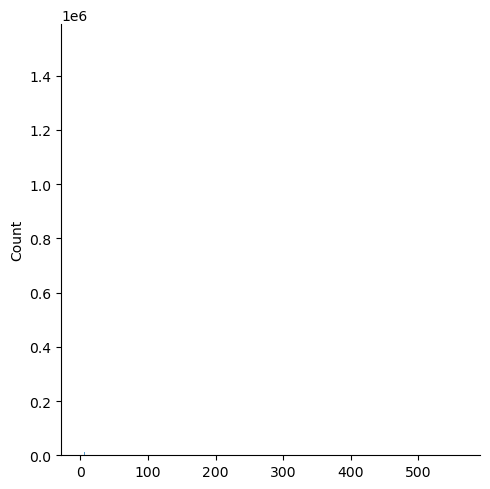

In [90]:
sns.displot(node_out_degree)

In [19]:
x_fraud_l2norm = np.linalg.norm(x[index_fraud], ord=2, axis=-1)
x_fraud_l2norm

array([2.8885317 , 2.95864555, 2.95864555, ..., 2.86736514, 4.43038281,
       3.86492392])

In [26]:
x_benign_l2norm = np.linalg.norm(x[index_benign], ord=2, axis=-1)
x_benign_l2norm, x_benign_l2norm.mean(), x_benign_l2norm.max()

(array([5.06804637, 2.97363824, 6.16812524, ..., 3.78764851, 3.78764851,
        3.78764851]),
 4.2309404456454445,
 638.1521954235086)

In [23]:
x_fraud_l2norm.mean()

3.359040676034683

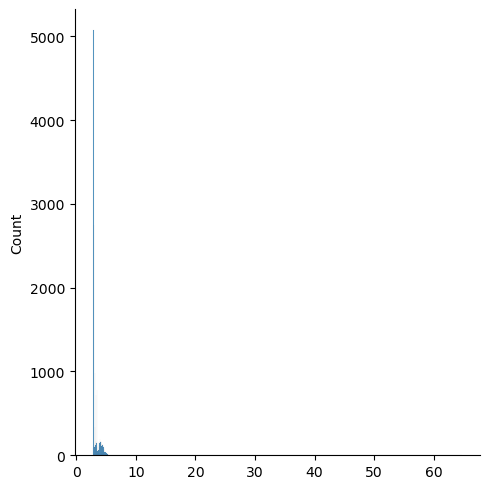

In [20]:
sns.displot(x_fraud_l2norm)

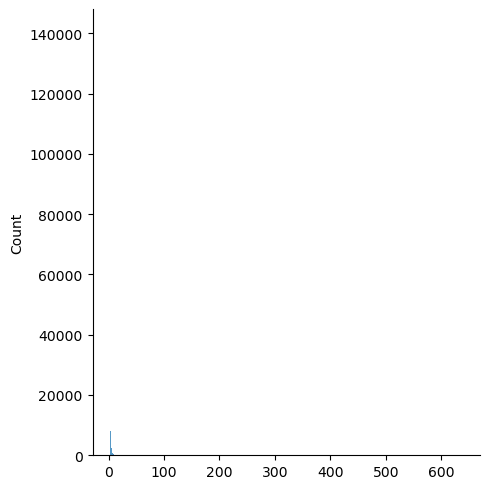

In [27]:
sns.displot(x_benign_l2norm)

### 二阶邻居

In [11]:
N = x.shape[0]
adj = pyg_utils.to_torch_csr_tensor(torch.tensor(edge_index), size=(N, N))
edge_index2, _ = pyg_utils.to_edge_index(adj @ adj)
edge_index2, _ = pyg_utils.remove_self_loops(edge_index2)

/home/shawn/anaconda3/envs/torch/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:176: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csr()


In [13]:
edge_index2, edge_index2.shape

(tensor([[      0,       0,       0,  ..., 3700547, 3700549, 3700549],
         [1343582, 1753508, 3086452,  ..., 1692468, 1355158, 1831551]]),
 torch.Size([2, 5892823]))

In [20]:
use_edge_index = edge_index2
benign_benign_neighbor_mask = (y[use_edge_index[0]] == 0) * (y[use_edge_index[1]] == 0)
fraud_fraud_neighbor_mask = (y[use_edge_index[0]] == 1) * (y[use_edge_index[1]] == 1)
benign_src_mask = y[use_edge_index[0]] == 0
fraud_dst_mask = y[use_edge_index[1]] == 1
fraud_src_mask = y[use_edge_index[0]] == 1
benign_fraud_neighbor_mask = benign_src_mask * fraud_dst_mask

fraud_neighbor_labels = pd.DataFrame(y[use_edge_index[1]][fraud_src_mask], columns=["y"])
fraud_neighbor_labels.value_counts()

y
0    8630
2    7817
3    4416
1      86
dtype: int64

<Axes: xlabel='y', ylabel='count'>

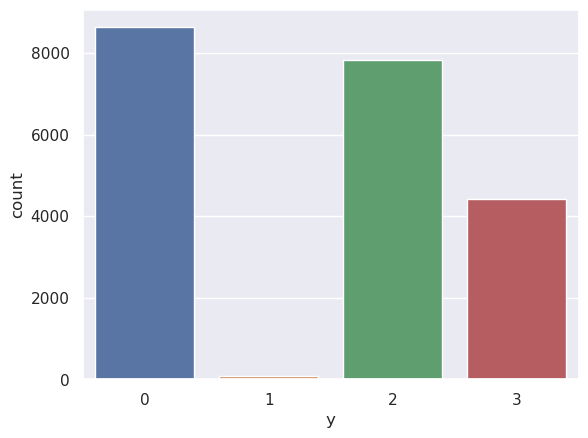

In [21]:
sns.countplot(x=fraud_neighbor_labels["y"])

max neighbor similarity: 1.0000000000000002
min neighbor similarity: -0.9278694572086056
mean neighbor similarity: 0.02126733632134702
std neighbor similarity: 0.7038375088410727


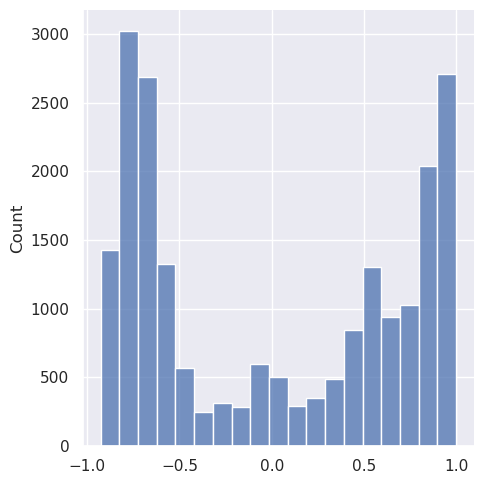

In [22]:
plot_neighbor_similarity(fraud_src_mask, torch.cosine_similarity)

max neighbor similarity: 1.0000000000000002
min neighbor similarity: -0.9359744653939424
mean neighbor similarity: 0.019298275183979207
std neighbor similarity: 0.6858654247735875


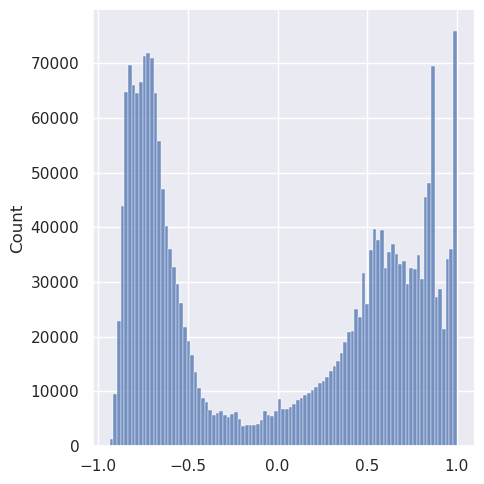

In [23]:
plot_neighbor_similarity(benign_src_mask, torch.cosine_similarity)

In [41]:
sb = torch.tensor([1, 0, 1], dtype=torch.float)
sb2 = torch.tensor([0, 1, 1], dtype=torch.float)
sb3 = torch.tensor([3, 0, 3], dtype=torch.float)

In [30]:
torch.cosine_similarity(sb, sb2, dim=0)

tensor(0.)

In [44]:
l2_similarity_alt(sb, sb2), l2_similarity_alt(sb, sb3)

(tensor(0.2431), tensor(0.0591))

## Elliptic

In [2]:
features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv", skiprows=1, header=None)
features

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203763,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203764,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203765,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203766,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [5]:
classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


In [6]:
edge_list = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
edge_list

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


## Etherenum

In [2]:
def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
    
def _get_mean_out_time_interval(series: pd.core.series.Series) -> pd.core.series.Series:
    if series.shape[0] <= 1:
        return 0
    return np.diff(np.sort(series)).mean()

graph = load_pickle('./Ethereum-Phishing-Transaction-Network/MulDiGraph.pkl')

adj = nx.to_scipy_sparse_array(graph, format="coo")
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

y = [graph.nodes[node]['isp'] for _, node in enumerate(nx.nodes(graph))]
edge_time = [graph[u][v][0]['timestamp'] for _, (u, v) in enumerate(nx.edges(graph))]

y = torch.tensor(y, dtype=torch.int64)
edge_time = torch.tensor(edge_time, dtype=torch.int64)

node_out_times = pd.DataFrame(
    np.concatenate(
        (edge_index[0].reshape(-1, 1), edge_time.int().reshape(-1, 1)), axis=-1),
    columns=["node_out", "time"])
edge_mean_out_time_interval = node_out_times.groupby("node_out").agg(_get_mean_out_time_interval)
node_mean_out_time_interval = np.zeros(y.shape[0])
node_mean_out_time_interval[edge_mean_out_time_interval.index] = edge_mean_out_time_interval.values.flatten()
node_mean_out_time_interval = torch.tensor(node_mean_out_time_interval.reshape(-1, 1),
                                           dtype=edge_time.dtype)

ethereum = Data(y=y, edge_index=edge_index, edge_time=edge_time, num_nodes=y.shape[0], node_mean_out_time_interval=node_mean_out_time_interval)
ethereum

Data(edge_index=[2, 13551303], y=[2973489], edge_time=[13551303], num_nodes=2973489, node_mean_out_time_interval=[2973489, 1])

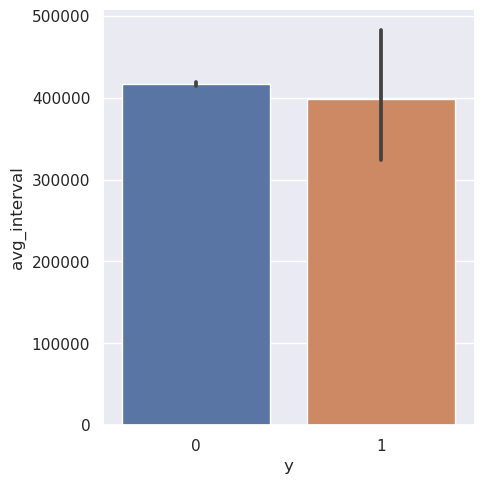

In [3]:
plot_temporal_frequency(ethereum)

In [10]:
data.num_edges

5355155

## PyTorch Playground

In [7]:
from sklearn.manifold import TSNE
out = torch.rand((50, 16))
y = torch.zeros(50).int()
y[:10] = 1
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(out)

column_titles = ["x1", "x2", "y"]
df = pd.DataFrame(np.concatenate((X_embedded, y.reshape(-1,1)), axis=-1))
df.columns = column_titles

sns.scatterplot(df, x="x1", y="x2", hue="y")

TypeError: scatter() got multiple values for argument 'x'

<Axes: >

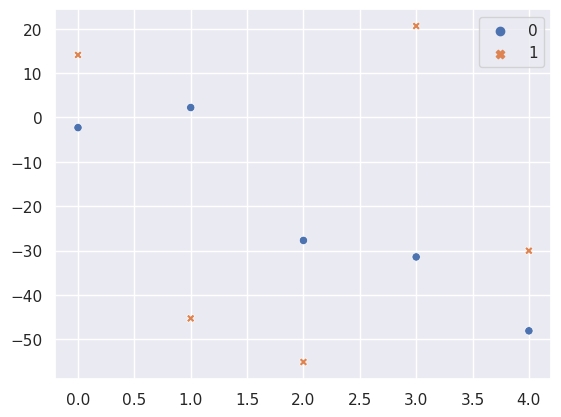

In [5]:
torch.tensor([1,2,3]).shape[0]

3

In [15]:
from torch_sparse import SparseTensor
edge_index = torch.LongTensor(
    [[0, 0, 0, 1, 2, 1, 2, 3], [1, 2, 3, 2, 3, 5, 4, 6]])
adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(7, 7))
adj

SparseTensor(row=tensor([0, 0, 0, 1, 1, 2, 2, 3]),
             col=tensor([1, 2, 3, 2, 5, 3, 4, 6]),
             size=(7, 7), nnz=8, density=16.33%)

In [47]:
edge_time

array([254, 266, 240, ..., 378, 594, 112])

In [22]:
chosen = torch.tensor([0, 1])
idx_neighbor = torch.tensor([2, 3])
adj[chosen, :], adj[chosen, :] + adj[2, :]

(SparseTensor(row=tensor([0, 0, 0, 1, 1]),
              col=tensor([1, 2, 3, 2, 5]),
              size=(2, 7), nnz=5, density=35.71%),
 SparseTensor(row=tensor([0, 0, 0, 0, 1, 1]),
              col=tensor([1, 2, 3, 4, 2, 5]),
              size=(2, 7), nnz=6, density=42.86%))

In [46]:
adj.index_select(0, idx_neighbor)

SparseTensor(row=tensor([0, 0, 1]),
             col=tensor([3, 4, 6]),
             size=(2, 7), nnz=3, density=21.43%)

In [2]:
h = torch.arange(0, 24).float().reshape(6, 4)
h

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]])

In [9]:
h_0 = h[0]
h_0

tensor([0., 1., 2., 3.])

In [18]:
h_0.unsqueeze(-1).shape, a.shape

(torch.Size([4, 1]), torch.Size([1]))

In [7]:
import math
a = torch.nn.Parameter(torch.rand(1))
a

Parameter containing:
tensor([0.5455], requires_grad=True)

In [24]:
(h_0.unsqueeze(-1) @ a).unsqueeze(-1) @ h_0.unsqueeze(0)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5455, 1.0910, 1.6366],
        [0.0000, 1.0910, 2.1821, 3.2731],
        [0.0000, 1.6366, 3.2731, 4.9097]], grad_fn=<MmBackward0>)

In [42]:
h_0 @ a @ h_0

tensor(2.5437)

In [41]:
h_a

tensor([[ -3.9252,   8.0508,  -0.9978,  -1.1705],
        [ -8.8498,  20.3212,  -4.3974,  -0.7485],
        [-13.7744,  32.5917,  -7.7969,  -0.3265],
        [-18.6990,  44.8621, -11.1964,   0.0955],
        [-23.6237,  57.1326, -14.5959,   0.5175],
        [-28.5483,  69.4031, -17.9955,   0.9395]])

In [16]:
h_0 @ a

tensor([-2.9724, -0.8057,  2.1312,  1.8517])

In [45]:
h_0 @ a @ h[1]

tensor(9.8311)

In [4]:
a = torch.randn(4, 4)
a

tensor([[ 1.2263, -0.1479, -0.5308,  0.7737],
        [-1.1619, -0.4900, -0.2261,  0.5866],
        [-1.1234,  2.5758,  0.4927, -2.0073],
        [-0.1721,  1.1297, -0.5857,  0.7525]])

In [13]:
h_a = torch.matmul(h, a)
h_a

tensor([[ -3.9252,   8.0508,  -0.9978,  -1.1705],
        [ -8.8498,  20.3212,  -4.3974,  -0.7485],
        [-13.7744,  32.5917,  -7.7969,  -0.3265],
        [-18.6990,  44.8621, -11.1964,   0.0955],
        [-23.6237,  57.1326, -14.5959,   0.5175],
        [-28.5483,  69.4031, -17.9955,   0.9395]])

In [17]:
torch.matmul(h_a.unsqueeze(-1), h)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (24x1 and 6x4)

In [27]:
h_a.unsqueeze(1) @ h

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x4 and 6x4)

In [30]:
h_a.unsqueeze(1) @ h.unsqueeze(1)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [6, 4] but got: [6, 1].

In [32]:
out = torch.zeros(6).float()
out

tensor([0., 0., 0., 0., 0., 0.])

In [39]:
for i in range(6):
    out[i] = h_a[i] @ h[i]
out

tensor([  9.0119,  22.5206,  42.7797,  69.7893, 103.5494, 144.0598])

In [38]:
h_a[0] @ h

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 6x4)

In [46]:
(h_a @ h.T)

tensor([[  9.0119,   9.8311,  10.6504,  11.4696,  12.2889,  13.1081],
        [ 18.3261,  22.5206,  26.7151,  30.9095,  35.1040,  39.2985],
        [ 27.6403,  35.2100,  42.7797,  50.3494,  57.9191,  65.4888],
        [ 36.9545,  47.8995,  58.8444,  69.7893,  80.7343,  91.6793],
        [ 46.2688,  60.5889,  74.9091,  89.2293, 103.5494, 117.8696],
        [ 55.5830,  73.2784,  90.9738, 108.6691, 126.3645, 144.0598]])

In [49]:
f = torch.nn.functional.relu(h_a @ h.T)
f

tensor([[  9.0119,   9.8311,  10.6504,  11.4696,  12.2889,  13.1081],
        [ 18.3261,  22.5206,  26.7151,  30.9095,  35.1040,  39.2985],
        [ 27.6403,  35.2100,  42.7797,  50.3494,  57.9191,  65.4888],
        [ 36.9545,  47.8995,  58.8444,  69.7893,  80.7343,  91.6793],
        [ 46.2688,  60.5889,  74.9091,  89.2293, 103.5494, 117.8696],
        [ 55.5830,  73.2784,  90.9738, 108.6691, 126.3645, 144.0598]])

In [51]:
h_0 @ h_0 @ h_0

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 1D

In [52]:
h.T @ h

tensor([[ 880.,  940., 1000., 1060.],
        [ 940., 1006., 1072., 1138.],
        [1000., 1072., 1144., 1216.],
        [1060., 1138., 1216., 1294.]])

In [5]:
a_0 = a[0]
a_0

tensor([ 1.2263, -0.1479, -0.5308,  0.7737])

In [56]:
h_0 @ a_0 @ h_0

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 1D

In [15]:
h_a.unsqueeze(-1).shape

torch.Size([6, 4, 1])

In [16]:
h.unsqueeze(1).shape

torch.Size([6, 1, 4])

In [44]:
torch.bmm(h_a.unsqueeze(1), h.unsqueeze(-1))

tensor([[[  2.5437]],

        [[ 34.5835]],

        [[101.5697]],

        [[203.5023]],

        [[340.3815]],

        [[512.2070]]])

In [19]:
h_a_h = torch.bmm(h_a.unsqueeze(-1), h.unsqueeze(1))
h_a_h.shape

torch.Size([6, 4, 4])

In [27]:
p = h_a_h.mean(1)
q = h_a_h.mean(-1)
p.shape

torch.Size([6, 4])

In [31]:
p

tensor([[  0.0000,   0.4893,   0.9786,   1.4680],
        [  6.3256,   7.9070,   9.4884,  11.0698],
        [ 21.3878,  24.0613,  26.7347,  29.4082],
        [ 45.1866,  48.9522,  52.7177,  56.4833],
        [ 77.7220,  82.5797,  87.4373,  92.2949],
        [118.9941, 124.9438, 130.8935, 136.8432]])

In [34]:
a_p = torch.nn.functional.softmax(p, dim=-1)
a_p

tensor([[1.0382e-01, 1.6934e-01, 2.7624e-01, 4.5060e-01],
        [6.9245e-03, 3.3665e-02, 1.6367e-01, 7.9574e-01],
        [3.0600e-04, 4.4341e-03, 6.4250e-02, 9.3101e-01],
        [1.2127e-05, 5.2373e-04, 2.2619e-02, 9.7685e-01],
        [4.6526e-07, 5.9888e-05, 7.7086e-03, 9.9223e-01],
        [1.7664e-08, 6.7766e-06, 2.5998e-03, 9.9739e-01]])

In [35]:
h * a_p

tensor([[0.0000e+00, 1.6934e-01, 5.5248e-01, 1.3518e+00],
        [2.7698e-02, 1.6833e-01, 9.8204e-01, 5.5702e+00],
        [2.4480e-03, 3.9906e-02, 6.4250e-01, 1.0241e+01],
        [1.4552e-04, 6.8085e-03, 3.1666e-01, 1.4653e+01],
        [7.4441e-06, 1.0181e-03, 1.3875e-01, 1.8852e+01],
        [3.5329e-07, 1.4231e-04, 5.7195e-02, 2.2940e+01]])

In [36]:
h_a_h

tensor([[[ 0.0000e+00, -3.9252e+00, -7.8503e+00, -1.1776e+01],
         [ 0.0000e+00,  8.0508e+00,  1.6102e+01,  2.4152e+01],
         [ 0.0000e+00, -9.9782e-01, -1.9956e+00, -2.9935e+00],
         [ 0.0000e+00, -1.1705e+00, -2.3410e+00, -3.5115e+00]],

        [[-3.5399e+01, -4.4249e+01, -5.3099e+01, -6.1949e+01],
         [ 8.1285e+01,  1.0161e+02,  1.2193e+02,  1.4225e+02],
         [-1.7589e+01, -2.1987e+01, -2.6384e+01, -3.0781e+01],
         [-2.9939e+00, -3.7424e+00, -4.4909e+00, -5.2394e+00]],

        [[-1.1020e+02, -1.2397e+02, -1.3774e+02, -1.5152e+02],
         [ 2.6073e+02,  2.9333e+02,  3.2592e+02,  3.5851e+02],
         [-6.2375e+01, -7.0172e+01, -7.7969e+01, -8.5766e+01],
         [-2.6118e+00, -2.9383e+00, -3.2648e+00, -3.5913e+00]],

        [[-2.2439e+02, -2.4309e+02, -2.6179e+02, -2.8049e+02],
         [ 5.3835e+02,  5.8321e+02,  6.2807e+02,  6.7293e+02],
         [-1.3436e+02, -1.4555e+02, -1.5675e+02, -1.6795e+02],
         [ 1.1463e+00,  1.2418e+00,  1.3373e+00, 

In [51]:
(h_0 @ a).reshape(-1, 1) @ h_0.unsqueeze(-1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1 and 4x1)

In [52]:
(h_0 @ a).reshape(-1, 1)

tensor([[-3.9252],
        [ 8.0508],
        [-0.9978],
        [-1.1705]])

In [56]:
h_0.unsqueeze(-1)

tensor([[0.],
        [1.],
        [2.],
        [3.]])

In [4]:
sb = torch.arange(0, 6).float().reshape(6, -1)
sb

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])

In [5]:
h, h * sb

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.],
         [16., 17., 18., 19.],
         [20., 21., 22., 23.]]),
 tensor([[  0.,   0.,   0.,   0.],
         [  4.,   5.,   6.,   7.],
         [ 16.,  18.,  20.,  22.],
         [ 36.,  39.,  42.,  45.],
         [ 64.,  68.,  72.,  76.],
         [100., 105., 110., 115.]]))

In [6]:
h[:, 0]

tensor([ 0.,  4.,  8., 12., 16., 20.])

In [11]:
h * h[:, 0]

RuntimeError: The size of tensor a (4) must match the size of tensor b (6) at non-singleton dimension 1

In [12]:
h[:, [0]]

tensor([[ 0.],
        [ 4.],
        [ 8.],
        [12.],
        [16.],
        [20.]])

In [53]:
a = torch.tensor([1,2,3])
b = torch.tensor([3,6,0])
c = torch.stack((a, b), dim=0)
c

tensor([[1, 2, 3],
        [3, 6, 0]])

In [56]:
torch.min(c, dim=0)[0]

tensor([1, 2, 0])

In [59]:
torch.randint_like(a, low=0, high=5)

tensor([0, 1, 2])

In [61]:
a.shape[0]

3

## CAFD数据分析

In [17]:
import os
import matplotlib
_PLOTS_PATH = "./plots"

sns.set_theme(style="whitegrid", palette="colorblind", font="Times New Roman", font_scale=1.2)
# config = {
#     "font.serif": ['Times New Roman']
# }
# matplotlib.rcParams.update(config)

In [3]:
temporal_frequency_comparison = pd.DataFrame({
    'avg_time_interval': [2.82, 0.57],
    'y': ["Benign users", "Fraudsters"]
})
temporal_frequency_comparison

,avg_time_interval,y
0,2.82,Benign users
1,0.57,Fraudsters


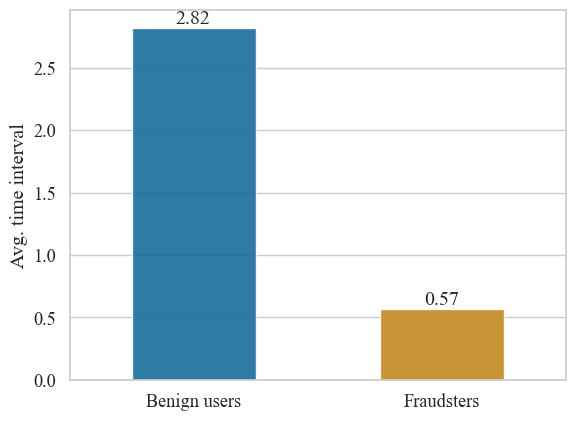

In [32]:

plot = sns.barplot(
    data=temporal_frequency_comparison,
    x="y", y="avg_time_interval", alpha=.9, width=0.5
)
# plot.despine(left=True)
# plot.set_axis_labels("", "Avg. time interval")
plt.xlabel("")
plt.ylabel("Avg. time interval")
plot.bar_label(plot.containers[0])
filename = "temporal-frequency-DGraph.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))
# plot.legend.set_title("")

In [8]:
degree_comparison_dgraph = pd.DataFrame({
    'avg_out_degree': [1.72, 0.75],
    'y': ["Benign users", "Fraudsters"]
})
degree_comparison_dgraph

,avg_out_degree,y
0,1.72,Benign users
1,0.75,Fraudsters


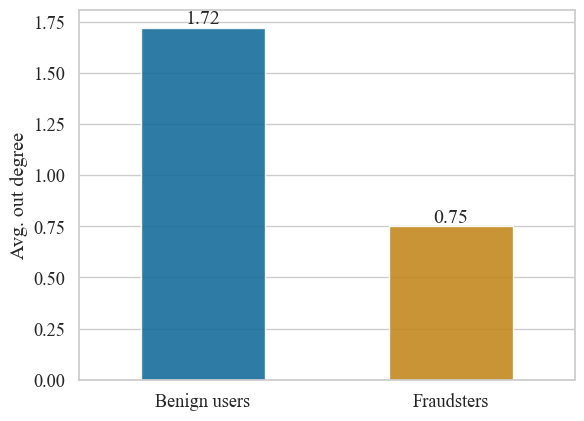

In [33]:
plot = sns.barplot(
    data=degree_comparison_dgraph,
    x="y", y="avg_out_degree", alpha=.9, width=0.5
)

plt.xlabel("")
plt.ylabel("Avg. out degree")
plot.bar_label(plot.containers[0])
filename = "out-degree-DGraph.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

In [10]:
degree_comparison_yelp = pd.DataFrame({
    'avg_out_degree': [168.6, 160.1],
    'y': ["Benign users", "Fraudsters"]
})
degree_comparison_yelp

,avg_out_degree,y
0,168.6,Benign users
1,160.1,Fraudsters


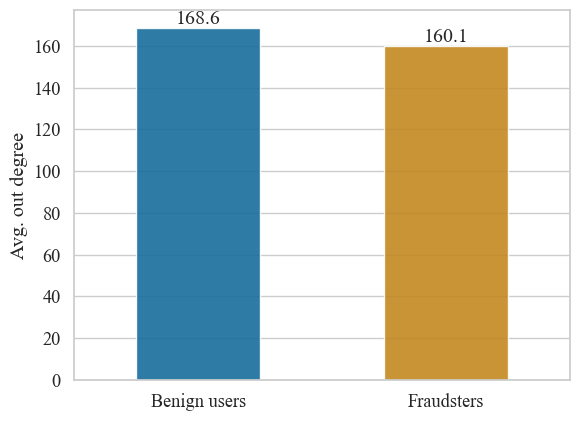

In [34]:
plot = sns.barplot(
    data=degree_comparison_yelp,
    x="y", y="avg_out_degree", alpha=.9, width=0.5
)

plt.xlabel("")
plt.ylabel("Avg. out degree")
plot.bar_label(plot.containers[0])
filename = "out-degree-Yelp.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

In [12]:
label_similarity_comparison = pd.DataFrame({
    'label_similarity': [0.26, 0.01, 0.77, 0.1],
    'dataset': ["DGraph", "DGraph", "Yelp", "Yelp"],
    'y': ["Benign users", "Fraudsters", "Benign users", "Fraudsters"]
})
label_similarity_comparison

,label_similarity,dataset,y
0,0.26,DGraph,Benign users
1,0.01,DGraph,Fraudsters
2,0.77,Yelp,Benign users
3,0.10,Yelp,Fraudsters


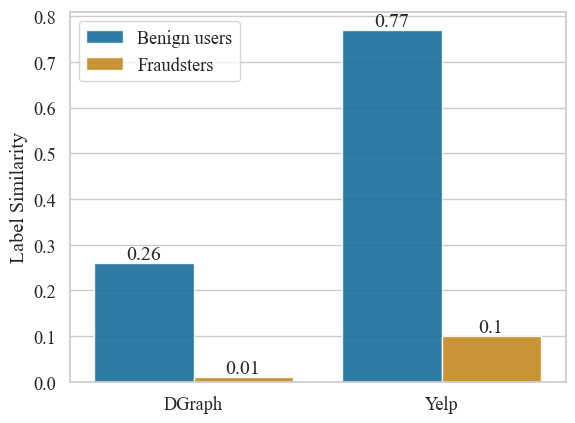

In [35]:
plot = sns.barplot(
    data=label_similarity_comparison,
    x="dataset", y="label_similarity", hue="y", alpha=.9
)

plt.xlabel("")
plt.ylabel("Label Similarity")
plt.legend()
plot.bar_label(plot.containers[0])
plot.bar_label(plot.containers[1])
filename = "label-similarity-comparison.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

In [3]:
ablation_study = pd.DataFrame({
    'AUC': [0.8396, 0.8379, 0.8360, 0.7995, 0.8671, 0.8585, 0.8350, 0.8558],
    'AP': [0.5300, 0.5295, 0.5288, 0.5214, 0.8010, 0.7806, 0.7547, 0.7719],
    'model': ["CAFD", "CAFD w/ Fixed Drop Rate", "CAFD/AA", "CAFD/CE", "CAFD", "CAFD w/ Fixed Drop Rate", "CAFD/AA", "CAFD/CE"],
    'dataset': ["DGraph", "DGraph", "DGraph", "DGraph", "Yelp", "Yelp", "Yelp", "Yelp"]
})
ablation_study

,AUC,AP,model,dataset
0,0.8396,0.5300,CAFD,DGraph
1,0.8379,0.5295,CAFD w/ Fixed Drop Rate,DGraph
2,0.8360,0.5288,CAFD/AA,DGraph
3,0.7995,0.5214,CAFD/CE,DGraph
4,0.8671,0.8010,CAFD,Yelp
5,0.8585,0.7806,CAFD w/ Fixed Drop Rate,Yelp
6,0.8350,0.7547,CAFD/AA,Yelp
7,0.8558,0.7719,CAFD/CE,Yelp


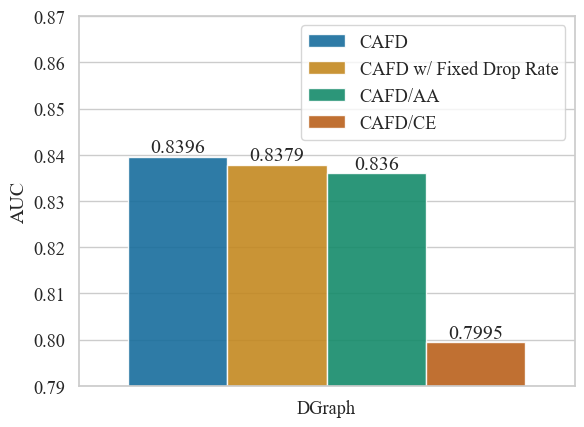

In [9]:
plot = sns.barplot(
    data=ablation_study[ablation_study["dataset"] == "DGraph"],
    x="dataset", y="AUC", hue="model", alpha=.9
)

plt.xlabel("")
plt.ylabel("AUC")
plt.legend()
plot.bar_label(plot.containers[0])
plot.bar_label(plot.containers[1])
plot.bar_label(plot.containers[2])
plot.bar_label(plot.containers[3])
plot.set_ylim(bottom=0.79, top=0.87)
filename = "ablation-auc-dgraph.png"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

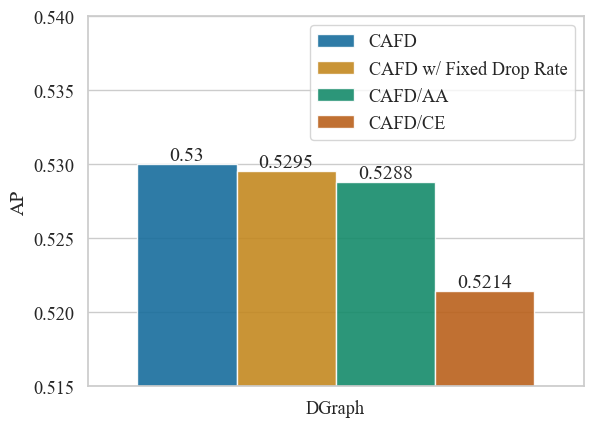

In [11]:
plot = sns.barplot(
    data=ablation_study[ablation_study["dataset"] == "DGraph"],
    x="dataset", y="AP", hue="model", alpha=.9
)

plt.xlabel("")
plt.ylabel("AP")
plt.legend()
plot.bar_label(plot.containers[0])
plot.bar_label(plot.containers[1])
plot.bar_label(plot.containers[2])
plot.bar_label(plot.containers[3])
plot.set_ylim(bottom=0.515, top=0.54)
filename = "ablation-ap-dgraph.png"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

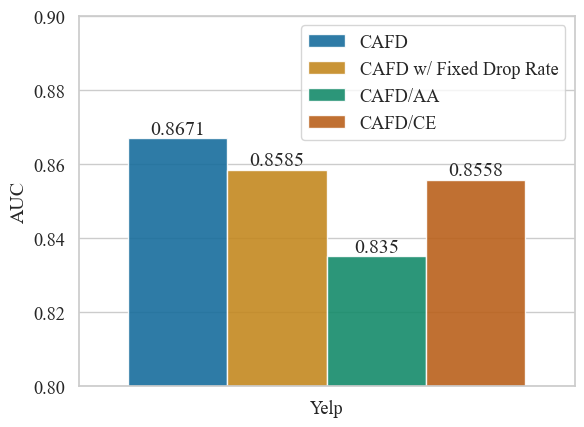

In [18]:
plot = sns.barplot(
    data=ablation_study[ablation_study["dataset"] == "Yelp"],
    x="dataset", y="AUC", hue="model", alpha=.9
)

plt.xlabel("")
plt.ylabel("AUC")
plt.legend()
plot.bar_label(plot.containers[0])
plot.bar_label(plot.containers[1])
plot.bar_label(plot.containers[2])
plot.bar_label(plot.containers[3])
plot.set_ylim(bottom=0.8, top=0.9)
filename = "ablation-auc-yelp-revised.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

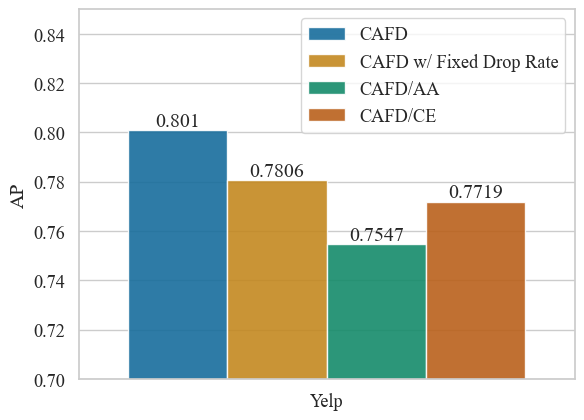

In [21]:
plot = sns.barplot(
    data=ablation_study[ablation_study["dataset"] == "Yelp"],
    x="dataset", y="AP", hue="model", alpha=.9
)

plt.xlabel("")
plt.ylabel("AP")
plt.legend()
plot.bar_label(plot.containers[0])
plot.bar_label(plot.containers[1])
plot.bar_label(plot.containers[2])
plot.bar_label(plot.containers[3])
plot.set_ylim(bottom=0.7, top=0.85)
filename = "ablation-ap-yelp-revised.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

In [12]:
sensitive_study = pd.DataFrame({
    'AUC': [0.8371, 0.8396, 0.8391, 0.8403, 0.8665, 0.8671, 0.8445, 0.8571],
    'AP': [0.5286, 0.5300, 0.5295, 0.5296, 0.7986, 0.8010, 0.7634, 0.7815],
    # 'encoding_size': ["4", "8", "16", "32", "4", "8", "16", "32"],
    'encoding_size': [4, 8, 16, 32, 4, 8, 16, 32],
    'dataset': ["DGraph", "DGraph", "DGraph", "DGraph", "Yelp", "Yelp", "Yelp", "Yelp"]
})
sensitive_study

,AUC,AP,encoding_size,dataset
0,0.8371,0.5286,4,DGraph
1,0.8396,0.5300,8,DGraph
2,0.8391,0.5295,16,DGraph
3,0.8403,0.5296,32,DGraph
4,0.8665,0.7986,4,Yelp
5,0.8671,0.8010,8,Yelp
6,0.8445,0.7634,16,Yelp
7,0.8571,0.7815,32,Yelp


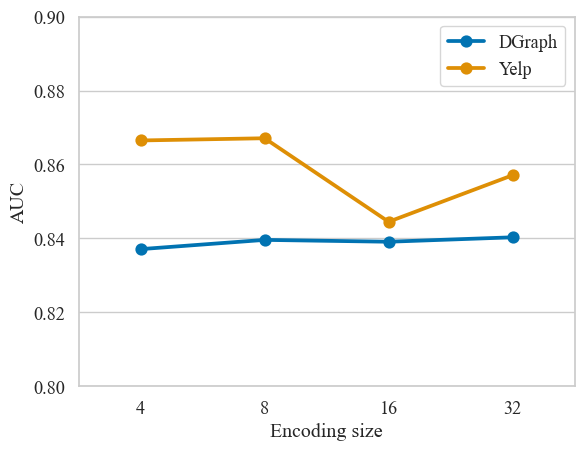

In [18]:
plot = sns.pointplot(
    data=sensitive_study,
    x="encoding_size", y="AUC", hue="dataset"
)

plt.xlabel("Encoding size")
plt.ylabel("AUC")
plt.legend()

plot.set_ylim(bottom=0.8, top=0.9)
filename = "sensitive-auc.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

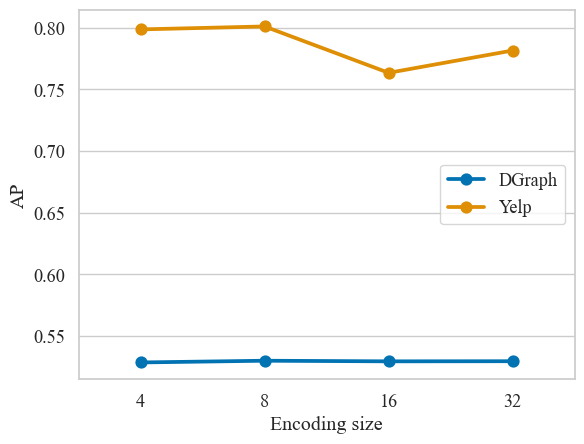

In [19]:
plot = sns.pointplot(
    data=sensitive_study,
    x="encoding_size", y="AP", hue="dataset"
)

plt.xlabel("Encoding size")
plt.ylabel("AP")
plt.legend()

# plot.set_ylim(bottom=0.8, top=0.9)
filename = "sensitive-ap.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

In [37]:
# SAD DGraph
auc = [0.7934901046877674, 0.79085869270243, 0.789071087518322]
ap = [0.5108031630516052, 0.5098254084587097, 0.5100087523460388]
np.mean(auc), np.std(auc), np.mean(ap), np.std(ap)

(0.7911399616361731,
 0.0018149861975195998,
 0.5102124412854513,
 0.0004243566888136182)

In [40]:
# SAD Yelp
auc = [0.8495653967155485, 0.8426502349889285, 0.8477379699831593]
ap = [0.782577633857727, 0.7706344127655029, 0.777469277381897]
np.mean(auc), np.std(auc), np.mean(ap), np.std(ap)

(0.8466512005625454,
 0.00292582367394363,
 0.7768937746683756,
 0.004892752125637103)

In [38]:
train_ratio_study_bak = pd.DataFrame({
    'ratio': 
    [
        "70", "70", "70", "70", "70", "70", "70", "70", "70", "70", "70", "70",
        "50", "50", "50", "50", "50", "50", "50", "50", "50", "50", "50", "50",
        "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", 
        "10", "10", "10", "10", "10", "10", "10", "10", "10", "10", "10", "10"
    ],
    # 'ratio': [70, 70, 70, 
    #           70, 70, 70,
    #           70, 70, 70, 
    #           70, 70, 70,
    #           50, 50, 50,
    #           50, 50, 50,
    #           50, 50, 50,
    #           50, 50, 50,
    #           30, 30, 30,
    #           30, 30, 30,
    #           30, 30, 30,
    #           30, 30, 30,
    #           10, 10, 10,
    #           10, 10, 10,
    #           10, 10, 10,
    #           10, 10, 10
    #          ],
    'model': ["CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT"],
    'AUC': [0.8160461187362671, 0.8140177726745605, 0.8156982660293579, 
            0.7934901046877674, 0.79085869270243, 0.789071087518322, 
            0.7613, 0.7599, 0.7633,
            0.7965575456619263, 0.7997854948043823, 0.7962117195129395,
           
            0.812674, 0.812691, 0.812129,
            0.7925939925187908, 0.793219101459581, 0.792364283147126,
            0.7566, 0.7585, 0.7602,
            0.7930580377578735, 0.7969220280647278, 0.7973614931106567,
            
            0.8085794448852539, 0.8137019872665405, 0.8087804913520813,
            0.7876694523948534, 0.7906884421821387, 0.7895054341380454,
            0.7550, 0.7564, 0.7578,
            0.7908433675765991, 0.7914949059486389, 0.7924289703369141,
            
            0.7937065362930298, 0.8023531436920166, 0.8012325763702393,
            0.7872530483152094, 0.7810887346531716, 0.7873965298048304,
            0.7510, 0.7517, 0.7501,
            0.7908433675765991, 0.7914949059486389, 0.7924289703369141
           ],
    'AP': [0.5229695439338684, 0.5229300260543823, 0.5231549739837646, 
           0.5108031630516052, 0.5098254084587097, 0.5100087523460388, 
           0.5181, 0.5181, 0.5180,
           0.5210990309715271, 0.5216230154037476, 0.5209276676177979,
           
           0.522534, 0.522247, 0.522778,
           0.5106678009033203, 0.5110427737236023, 0.5110425353050232,
           0.5175, 0.5180, 0.5186,
           0.5202628970146179, 0.5206916928291321, 0.5206671357154846,
           
           0.5217998027801514, 0.5233232975006104, 0.5216058492660522,
           0.5102149248123169, 0.5096952319145203, 0.5104681849479675,
           0.5175, 0.5179, 0.5175,
           0.519608199596405, 0.5200905203819275, 0.5203964710235596,
           
           0.5190567374229431, 0.5209039449691772, 0.5200010538101196,
           0.5100823044776917, 0.5096094608306885, 0.509941577911377,
           0.5165, 0.5167, 0.5163,
           0.519608199596405, 0.5200905203819275, 0.5203964710235596
          ]
})

In [20]:
train_ratio_study = pd.DataFrame({
    'ratio': 
    [
        "10", "10", "10", "10", "10", "10", "10", "10", "10", "10", "10", "10",
        "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", "30", 
        "50", "50", "50", "50", "50", "50", "50", "50", "50", "50", "50", "50",
        "70", "70", "70", "70", "70", "70", "70", "70", "70", "70", "70", "70"
    ],
    'Model': ["CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT",
              "CAFD", "CAFD", "CAFD", 
              "SAD", "SAD", "SAD", 
              "GHRN", "GHRN", "GHRN",
              "TGAT", "TGAT", "TGAT"],
    'AUC': [
            # 10
            0.8121123313903809, 0.8113090991973877, 0.809162437915802,
            0.7872530483152094, 0.7810887346531716, 0.7873965298048304,
            0.7510, 0.7517, 0.7501,
            0.7908433675765991, 0.7914949059486389, 0.7924289703369141,
        
            # 30
            0.8329044580459595, 0.8319113850593567, 0.8300023674964905,
            0.7876694523948534, 0.7906884421821387, 0.7895054341380454,
            0.7550, 0.7564, 0.7578,
            0.7908433675765991, 0.7914949059486389, 0.7924289703369141,
        
            # 50
            0.8379909992218018, 0.8362682461738586, 0.8353888988494873,
            0.7925939925187908, 0.793219101459581, 0.792364283147126,
            0.7566, 0.7585, 0.7602,
            0.7930580377578735, 0.7969220280647278, 0.7973614931106567,
        
            # 70
            0.8398827314376831, 0.8395272493362427, 0.8394578695297241,
            0.7934901046877674, 0.79085869270243, 0.789071087518322, 
            0.7613, 0.7599, 0.7633,
            0.7965575456619263, 0.7997854948043823, 0.7962117195129395,
    ],
    'AP': [
            # 10
           0.5234674215316772, 0.5217944979667664, 0.52250075340271,
           0.5100823044776917, 0.5096094608306885, 0.509941577911377,
           0.5165, 0.5167, 0.5163,
           0.519608199596405, 0.5200905203819275, 0.5203964710235596,
        
            # 30
           0.5280720591545105, 0.5274427533149719, 0.5263412594795227,
           0.5102149248123169, 0.5096952319145203, 0.5104681849479675,
           0.5175, 0.5179, 0.5175,
           0.519608199596405, 0.5200905203819275, 0.5203964710235596,
        
            # 50
           0.5290265083312988, 0.5289484858512878, 0.5283788442611694,
           0.5106678009033203, 0.5110427737236023, 0.5110425353050232,
           0.5175, 0.5180, 0.5186,
           0.5202628970146179, 0.5206916928291321, 0.5206671357154846,
        
           # 70
           0.5302106142044067, 0.529964804649353, 0.5297379493713379,
           0.5108031630516052, 0.5098254084587097, 0.5100087523460388, 
           0.5181, 0.5181, 0.5180,
           0.5210990309715271, 0.5216230154037476, 0.5209276676177979
    ]
})

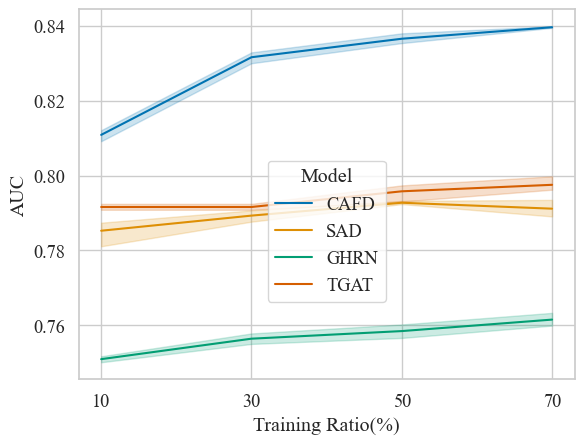

In [21]:
# Train ratio AUC
plot = sns.lineplot(train_ratio_study, x="ratio", y="AUC", hue="Model")
sns.move_legend(plot, loc="center", bbox_to_anchor=[0.5, 0.4])
plt.xlabel("Training Ratio(%)")
filename = "train-ratio-auc.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

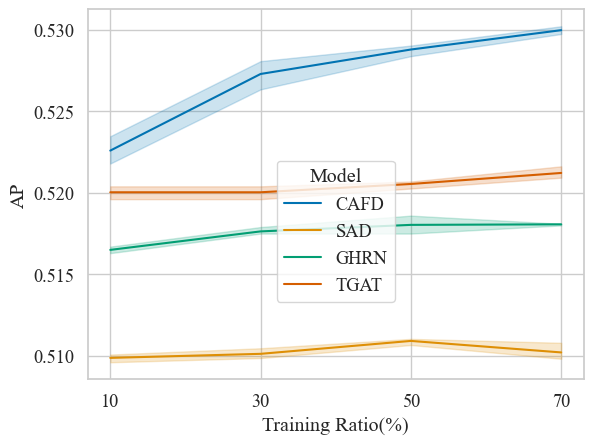

In [29]:
# Train ratio AP
plot = sns.lineplot(train_ratio_study, x="ratio", y="AP", hue="Model")
sns.move_legend(plot, loc="center", bbox_to_anchor=[0.5, 0.4])
plt.xlabel("Training Ratio(%)")
filename = "train-ratio-ap.pdf"
plot.get_figure().savefig(os.path.join(_PLOTS_PATH, filename))

## GADNR

In [2]:
import pygod
from pygod.detector import GADNR

In [3]:
model = GADNR(num_layers=1, epoch=20, hid_dim=32, verbose=2, batch_size=512)  # hyperparameters can be set here
model

GADNR(act=<function relu at 0x7f41e7ed8d30>,
      backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
      batch_size=512, compile_model=False, contamination=0.1,
      deg_dec_layers=4, dropout=0.0, epoch=20, fea_dec_layers=3, gpu=None,
      hid_dim=32, lambda_loss1=0.01, lambda_loss2=0.1, lambda_loss3=0.8,
      lr=0.01, neigh_loss='KL', num_layers=1, num_neigh=[-1],
      real_loss=True, sample_size=2, sample_time=3, save_emb=False,
      verbose=2, weight_decay=0.0003)

In [10]:
model.fit(yelp)

TypeError: MessagePassing.__init__() got an unexpected keyword argument 'tot_nodes'

In [11]:
from pygod.detector import DOMINANT

detector = DOMINANT(hid_dim=64, num_layers=4, epoch=100)

In [ ]:
detector.fit(yelp)